# RICH AI Exploratory Data Analysis

### Notes
- Labels are 0: Muon, 1: Pion, 2: Positron
- Likelihood labels are different [Pion, Muon, Positron]

### TODO

- Add more data
- Ring centre alignment still off

In [31]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob

# Helper functions 

In [32]:
def read_RICHAI_data(file_paths):
    """Read in all the 2018 RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    data_files = {}
    for file_path in file_paths:
        
        name = file_path.split("/")[4] + "/" + file_path.split("/")[5].split(".")[0]
            
                    
        patch_check=file_path.split("/")[5].split(".")[2]
        
        if len(patch_check.split("_")) == 2: 
                name=name + '_' + patch_check.split('_')[1]   
        
        data_files[name] = h5py.File(file_path)
    
    return data_files

In [33]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas
    
    Parameters
    ----------
    dfile : HDF5 file
        The RICHAI HDF5 file to convert to pandas.
        
    Returns
    -------
    df : pd.DataFrame
        pandas DataFrame with Events data
    """
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    # hit mapping values
    df["first_hit"] = np.array(dfile["HitMapping"])[:-1]  # hit n
    df["last_hit"] = np.array(dfile["HitMapping"])[1:]    # hit n + 1
    df["total_hits"] = df["last_hit"] - df["first_hit"]
    
    return df

In [34]:
def get_string_label(label):
    """Add string label to pandas df (to be used with map)"""
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

In [35]:
def compute_seq_id(hit, or_id=0):
    """Compute the RICH PMT sequence ID"""
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id, otypes=[int])

In [36]:
def realign_x_hits(x, mirror):
    if mirror == 0:
        return x - 146.8
    else:
        return x + 196.7
    
def realign_y_hits(y, mirror):
    if mirror == 0:
        return y - 19.8
    else:
        return y - 9.5

In [37]:
def get_hit_info_df(f, df, event):
    """Get the hit info for an event in a pandas dataframe
    
    Parameters
    ----------
    f : HDF5 file
        The RICHAI HDF5 file.
    df : pandas DataFrame
        A pandas DataFrame representation of the HDF5 Events file.
    event : int
        The event number to get the hit info for.
        
    Returns
    -------
    positions : pd.DataFrame
        pandas DataFrame with hits data for a given event
    """
    positions = []
    
    # get our hit data for this event
    idx_from = df.loc[event]["first_hit"]
    idx_to = df.loc[event]["last_hit"]
    hit_data = f["Hits"][idx_from:idx_to]
    
    # get our pm locations for this event
    for hit in hit_data:
        pm_idx = compute_seq_id(hit)
        positions.append(position_map[pm_idx])
    
    # add hit time, chod time, and delta
    positions = pd.DataFrame(positions, columns=["x", "y", "mirror"])
    positions["x_realigned"] = positions.apply(lambda a: realign_x_hits(a.x, a.mirror), axis=1)
    positions["y_realigned"] = positions.apply(lambda a: realign_y_hits(a.y, a.mirror), axis=1)
    positions["hit_time"] = hit_data["hit_time"]
    positions["chod_time"] = df["chod_time"][event]
    positions["chod_delta"] = positions["hit_time"] - positions["chod_time"]
    positions["class"] = df["class"][event]
    positions["event"] = event
    
    return positions

In [38]:
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [39]:
def get_class_samples(df, n, seed, momentum_bin=None, wide=None):
    """Sample n samples for each particle class from the events dataframe"""
    
    if momentum_bin and wide:
        df = df.query("wide_momentum_bin == @momentum_bin")
        
    if momentum_bin and not wide:
        df = df.query("narrow_momentum_bin == @momentum_bin")
        
    samples = pd.concat(
        [
            df[df["class"] == "muon"].sample(n=n, random_state=seed),
            df[df["class"] == "pion"].sample(n=n, random_state=seed),
           # df[df["class"] == "positron"].sample(n=n, random_state=seed)        
        ]

    )
    
    return samples

In [40]:
def get_string_label(label):
    """Add string label to pandas df (to be used with map)"""
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    #elif label == 2:
    #    return "positron"

In [41]:
def undersample(df):
    classes = df.label.value_counts().to_dict()
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [42]:
def delta(
    dset_unbalanced, 
    df_balanced, 
    delta = 0.3
):
    """extra delta stats"""
    
    # Event indices in balanced dataset
    event_nums = df_balanced['original_index']

    # Defining total_hits_filtered
    hits_filtered_perevent = pd.Series(np.zeros(df_balanced.shape[0], dtype='int32'), index=event_nums,dtype='int32')
    delta_perevent = pd.Series(np.zeros(df_balanced.shape[0], dtype='int32'), index=event_nums,dtype='int32')

    for event_idx in event_nums:
        # Finding the number of hits for each event in the hit_array from hit_mapping
        idx_from = dset_unbalanced.hit_mapping[event_idx]
        idx_to = dset_unbalanced.hit_mapping[event_idx+1]
        hit_times = dset_unbalanced.hit_array['hit_time'][idx_from:idx_to]

        # Extracting delta for each event
        delta_time = dset_unbalanced.event_array[event_idx]["chod_time"] - hit_times

        # Fetching the count of hit_times in the range hit_time +- delta_tolerance
        hits_filtered_perevent[event_idx] = delta_time[np.abs(delta_time) > delta].shape[0]
        delta_perevent[event_idx] = np.mean(delta_time[np.abs(delta_time) < delta])

    # updating df_balanced for total hits
    df_balanced_copy = df_balanced
    df_balanced_copy['hits_filtered_per_event'] = hits_filtered_perevent
    df_balanced_copy['mean_delta'] = delta_perevent
    
    print(delta_time)
    
    return df_balanced_copy

## Helper functions for plotting Rings

In [43]:
def get_hit_data(f, mapper, mapper_event):
    """Get the hit data for an event as a numpy array."""

    event=mapper['combined']['table'][mapper_event][3][1]
   
    hit_data = []
    
    # get the raw hit data, hit time, and chod time
    hits = f["Hits"][
        f["HitMapping"][event]:f["HitMapping"][event+1]
    ]
    hit_times = hits["hit_time"]
    chod_time = f["Events"][event]["chod_time"]
    
    # compute (x, y) positions
    for hit in hits:
        idx = compute_seq_id(
            disk_id=hit["disk_id"],
            up_dw_id=hit["updowndisk_id"],
            sc_id=hit["supercell_id"],
            pm_id=hit["pmt_id"],
            or_id=0
        )

        hit_data.append(position_map[idx])

    # convert (x, y) positions to numpy array
    hit_data = np.array(hit_data)

    # create array of chod times
    chod_time = np.full((hit_data.shape[0], 1), chod_time)

    # join hits, hit times, and chod time
    hit_data = np.c_[hit_data, hit_times, chod_time]

    # create CHOD - time delta column
    hit_data = np.append(hit_data, hit_data[:, 4:] - hit_data[:, 3:4], axis=1)
    
    # final columns are x, y, mirror, hit time, chod time, delta
    return hit_data


def hit_data_to_pandas(hit_data):
    """Convert numpy array hits data to pandas format"""
    return pd.DataFrame(
        data=hit_data,
        columns=["x", "y", "mirror", "hit_time", "chod_time", "time_delta"]
    )


def realign_x_hits(x, mirror):
    """Realign x hits based on mirror"""
    if mirror == 0:
        return x - 146.8
    else:
        return x - 196.7
    
    
def realign_y_hits(y, mirror):
    """Realign y hits based on mirror"""
    if mirror == 0:
        return y - 19.8
    else:
        return y - 9.5
    
    
def plot_event(f, mapper, mapper_event, ax=None):
    # get the hit data for the event
    hit_data = get_hit_data(f, mapper, mapper_event)
    
    event=mapper['combined']['table'][mapper_event][3][1]
    
    # convert data to pandas to make plotting code more readable
    hit_data_df = hit_data_to_pandas(hit_data)
    
    # realign x and y hits
    hit_data_df["x_realigned"] = hit_data_df.apply(
        lambda a: realign_x_hits(a.x, a.mirror), axis=1
    )
    hit_data_df["y_realigned"] = hit_data_df.apply(
        lambda a: realign_y_hits(a.y, a.mirror), axis=1
    )
     
    # get values for title
    radius = f["Events"][event]['ring_radius']
    momentum = f["Events"][event]['track_momentum']
    centre_x, centre_y = f["Events"][event]['ring_centre_pos']
    label = labels[event]
    
    # determine which mirror was hit
    if (hit_data[:, 2:3] == 0).all():
        mirror = "Jura"
    elif (hit_data[:, 2:3] == 1).all():
        mirror = "Saleve"
    else:
        mirror = "Both"
    
    if not ax:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.subplots()
    
    # plot realigned hits
    im = ax.scatter(
        x=hit_data_df["x_realigned"],
        y=hit_data_df["y_realigned"],
#         c=hit_data_df["time_delta"],
        c=np.power(hit_data_df["time_delta"], 2),
#         c=np.abs(hit_data_df["time_delta"]),
        cmap="cividis",
        vmin = 0, vmax=30
    )
    
    if label == 0:
        color = "#1170aa"
    elif label == 1:
        color = "#fc7d0b"
    elif label == 2:
        color = "#a3acb9"
    
    # plot the circle
    ax.add_artist(
        plt.Circle((centre_x, centre_y), radius, fill=False,color=color)
    )
    
    # add a colourbar
    cbar = plt.colorbar(im, shrink=0.5, ax=ax)
    
    # other customizations
    ax.set_title(
        f"""Event: {event}, Mirror:{mirror}
        Radius: {radius:.2f}, Momentum: {momentum:.2f}
        Centre ({centre_x:.2f}, {centre_y:.2f})
        Label: {label}""" 
    )
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_aspect('equal')
    ax.set_xlim(-500,500)
    ax.set_ylim(-500,500)
    
    return ax

# Read in data files

In [44]:
file_paths = glob.glob("/data/bvelghe/capstone2022/*/*")
data_files = read_RICHAI_data(file_paths)
data_files.keys()

dict_keys(['A/Run008563', 'A/Run008548', 'A/Run008564', 'A/Run008553', 'A/Run008562', 'C/2018E', 'C/2018E_patched', 'B/2018B'])

In [45]:
f = data_files['C/2018E_patched']
f.keys()

<KeysViewHDF5 ['Events', 'HitMapping', 'Hits']>

In [46]:
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

In [47]:
__file__ = "../utils/helpers.py"
SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.dirname(SCRIPT_DIR))
from dataset.rich_dataset import *
dset_path = "/data/bvelghe/capstone2022/C/2018E.EOSlist.CTRL_patched.h5"
dset_unbalanced = RICHDataset(
    dset_path
)

ModuleNotFoundError: No module named 'dataset.rich_dataset'

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

# Create `Events` pandas `DataFrame`

In [49]:
df = events_to_pandas(f)

# add class label (text)
df["class"] = df["label"].apply(get_string_label)

# add wide momentum bin
wide_momentum_bins = ['(0,10]', '(10,20]', '(20,30]', '(30,40]','(40,50]']
df["wide_momentum_bin"] = pd.cut(
    df["track_momentum"],
    [0, 10, 20, 30, 40, 50],
    labels=wide_momentum_bins
)

# add narrow momentum bin
narrow_momentum_bins = []

for i in range(0, 40):
    narrow_momentum_bins.append((i, i+1))

narrow_momentum_bins.append((40, np.inf))

df["narrow_momentum_bin"] = pd.cut(
    df["track_momentum"],
    pd.IntervalIndex.from_tuples(narrow_momentum_bins),
    labels=[f"({b[0]}, {b[1]}]" for b in narrow_momentum_bins]
)

df.shape

df=df[df['label']!=2]

In [50]:
#removing positrons and undersampling pions 
df_bi=df[(df['label']!=2)]
df_bi['original_index']=df_bi.index

#creating sub-samples for each bin 
wide_momentum_bins = ['(0,10]', '(10,20]', '(20,30]', '(30,40]','(40,50]']

balanced_df_wide={}
for i in wide_momentum_bins: 
    balanced_df_wide[i]=undersample(df_bi[df_bi['wide_momentum_bin']==i])
    
#combining dfs under each bin   
balanced_df_combined=pd.concat(balanced_df_wide, ignore_index=True)

In [51]:
#creating a smaller df with n=10000 samples under each bin
df_small={}

for key, value in balanced_df_wide.items():
    n_examples=int(value.shape[0]/2)
    
    if n_examples>30000:
        n=10000
    else: 
        n=n_examples

    df_small[key]=get_class_samples(value, n, seed=42)

df_small_combined=pd.concat(df_small.values(), ignore_index=True)

In [52]:
# this matches Bob's documentation on https://github.com/TRIUMF-Capstone2022/RICHPID/tree/main/docs
print(f'The class counts in the original dataset are: \n{df["class"].value_counts()} \n\nThe class counts in the synthetic dataset are: \n{balanced_df_combined["class"].value_counts()}'
     )

The class counts in the original dataset are: 
muon    8583495
pion     984155
Name: class, dtype: int64 

The class counts in the synthetic dataset are: 
muon    948838
pion    948838
Name: class, dtype: int64


# Plot settings

In [53]:
plt.style.use('tableau-colorblind10')
plt.rcParams["patch.force_edgecolor"] = True

# line styles for positron, pion, muon
lss = ['dashed', 'dashdot', "dotted"]

# Plots: Event Data

## Track momentum

### Momentum histograms - Bins = 1 GeV

- Muon has the widest range, pion a bit narrower.  Positron momentum range is much lower.
- Note positron has less data
- The bins here are a single GeV

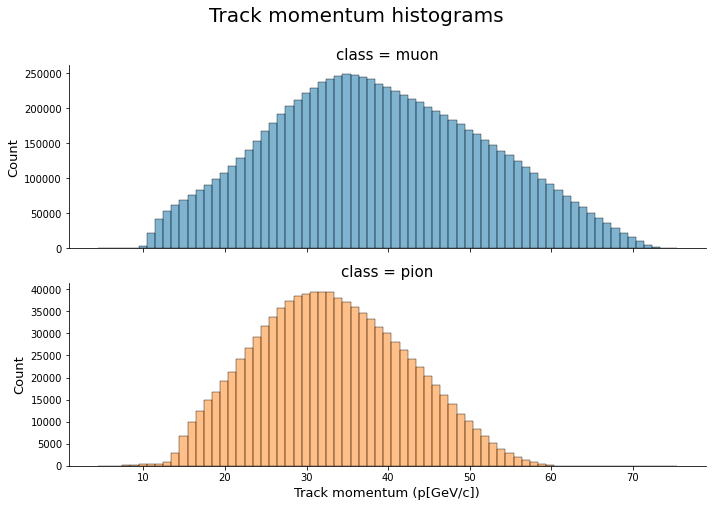

In [21]:
g = sns.displot(
    data=df,
    x="track_momentum",
    col="class",
    hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Track momentum histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Track momentum (p[GeV/c])", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


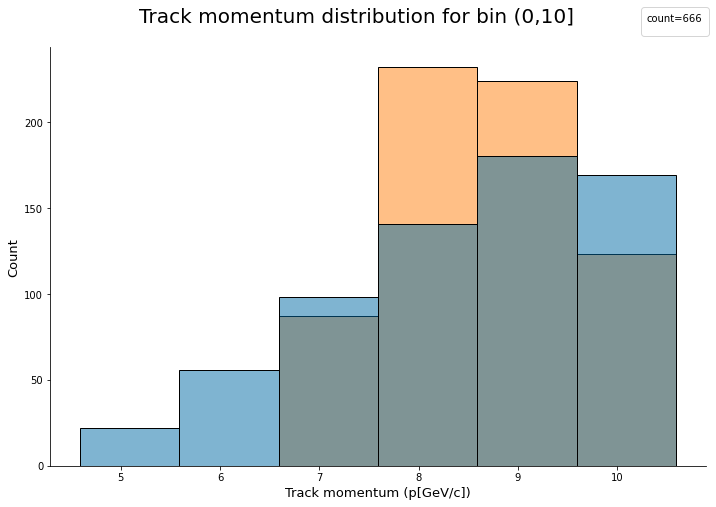

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


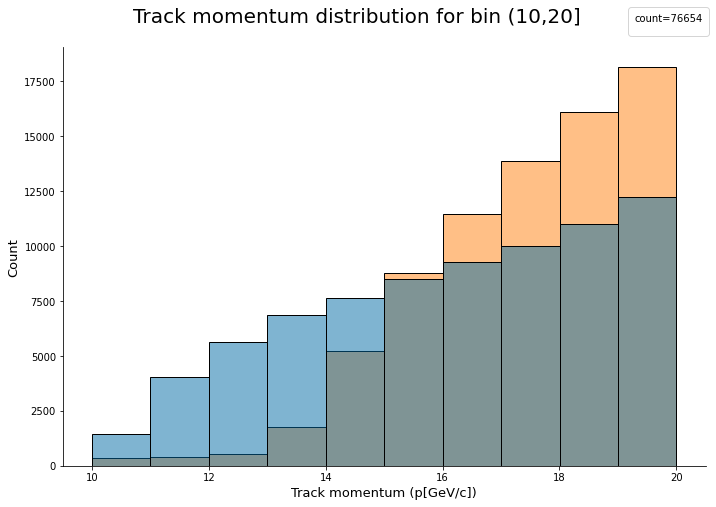

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


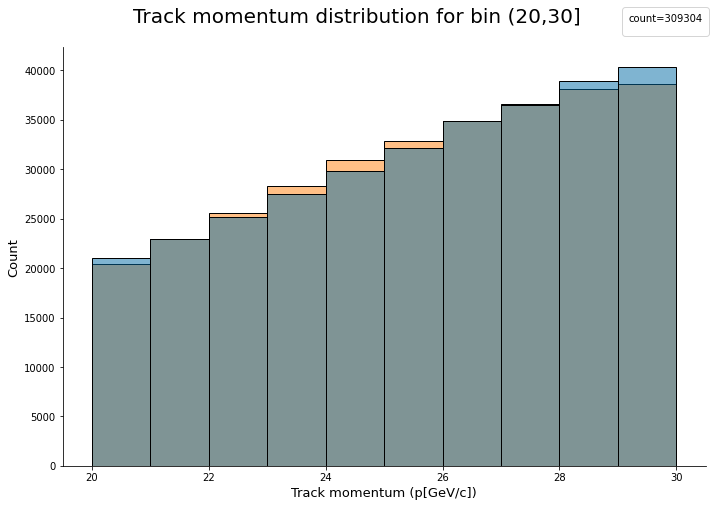

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


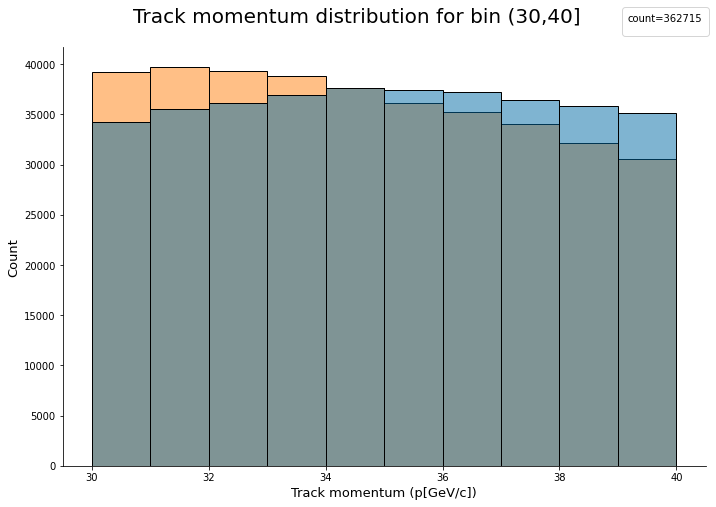

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


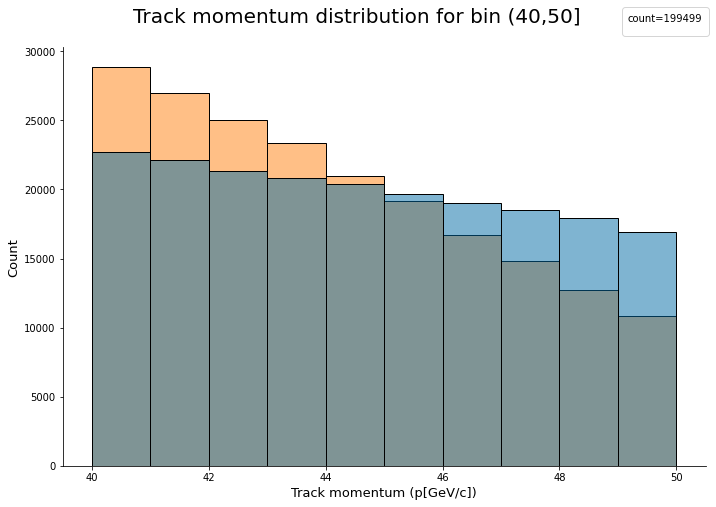

In [45]:
for key, value in balanced_df_wide.items():

    g = sns.displot(
        data=value,
        x="track_momentum",
        #col="class",
        hue="class",
        binwidth=1,
        facet_kws=dict(sharey=False),
        #col_wrap=1,
        legend=False,
        alpha=0.5
    )

    g.fig.suptitle(f"Track momentum distribution for bin {key}", y=1, fontsize=20)
    g.fig.legend(title=f"count={value.label.value_counts()[0]}", 
                fontsize=15)
    g.set_titles(size=15)
    g.set_xlabels("Track momentum (p[GeV/c])", fontsize=13)
    g.set_ylabels(fontsize=13)
    g.fig.set_figheight(7)
    g.fig.set_figwidth(10)

    plt.tight_layout()
    plt.show()

### Momentum KDE plot

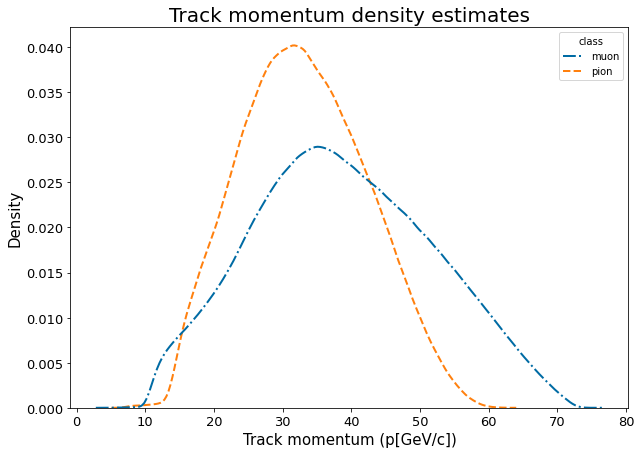

In [23]:
fig = plt.figure(figsize=(10, 7))
g = sns.kdeplot(df_bi["track_momentum"], hue=df["class"], common_norm=False, linewidth=2)

plt.title("Track momentum density estimates", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

handles = g.legend_.legendHandles[::-1]

for line, ls, handle in zip(g.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)

plt.show()

### Momentum Boxplots

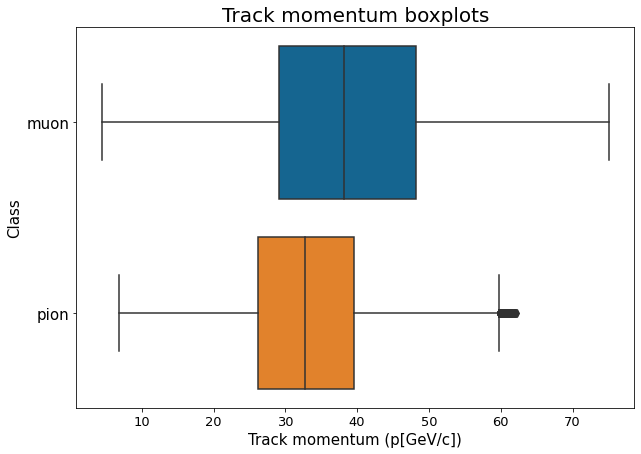

In [24]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="track_momentum", y="class")
plt.title("Track momentum boxplots", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Class", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.show()

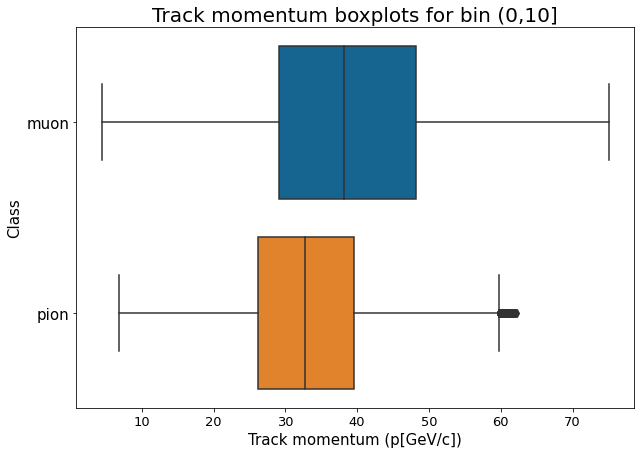

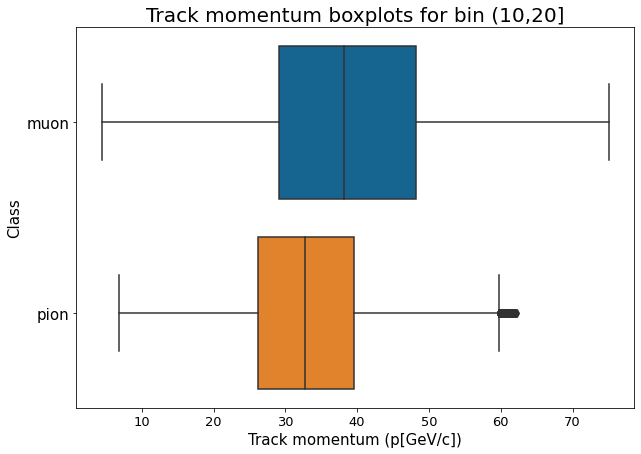

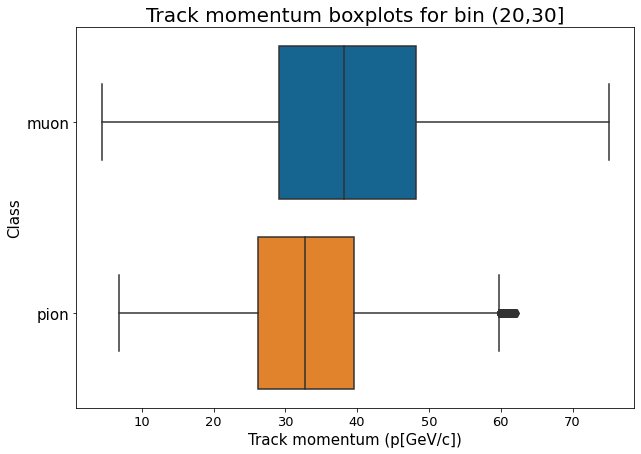

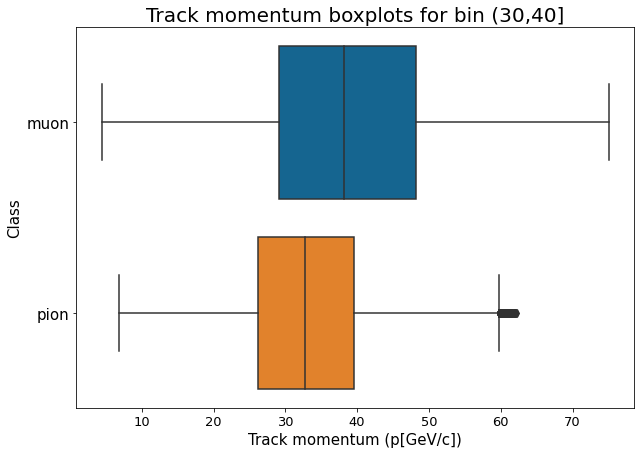

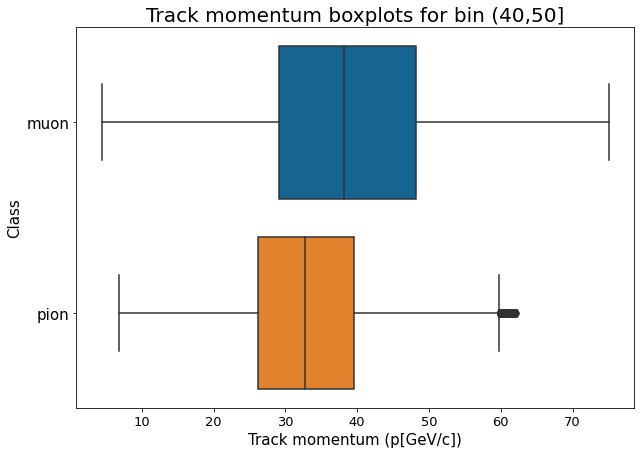

In [25]:
for key, value in balanced_df_wide.items():

    plt.figure(figsize=(10, 7))
    sns.boxplot(data=df, x="track_momentum", y="class")
    plt.title(f"Track momentum boxplots for bin {key}", fontsize=20)
    plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
    plt.ylabel("Class", fontsize=15);
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=15)
    plt.show()

## Ring radius

### MLE errors

<div class="alert alert-info" style="color:black">
Confirmed w/ TRIUMF that ring radii of 999999 represents a failure in the MLE algorithm.
</div>

In [26]:
counts = df[df["ring_radius"] >= 999999.000].shape[0]
print(f"There are {counts} examples with ring radius 999999")

There are 15587 examples with ring radius 999999


### Ring radius histograms - bins = 1 GeV

- Axis limits have been cut off here at > 120mm and < 220mm since this helps show plots better.  There is some noise outside of these limits.

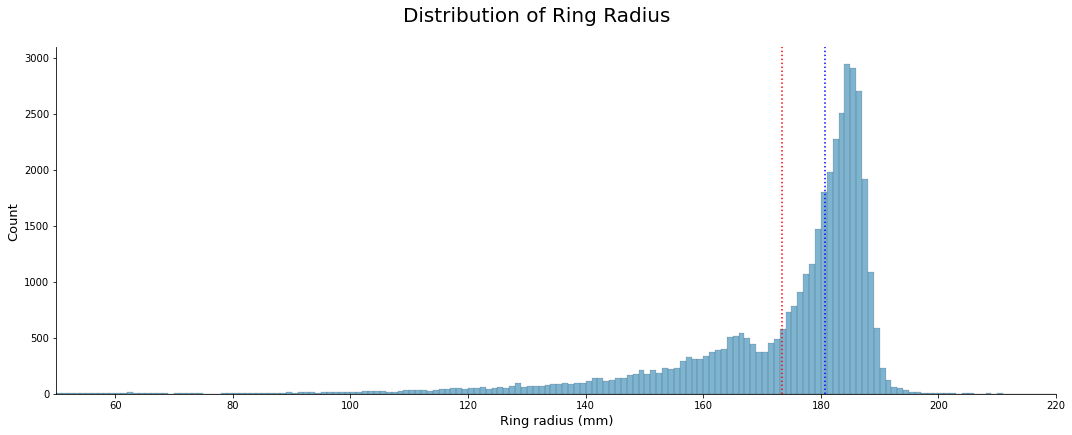

In [74]:
df=df_small_combined
g = sns.displot(
    data=df,
    x=df.query("ring_radius < 999999.000 & label == 0")["ring_radius"],
    #col=df.query("ring_radius < 999999.000")["class"],
    hue=df.query("ring_radius < 999999.000")["class"],
    binwidth=1,
    facet_kws=dict(sharey=False),
    #col_wrap=1,
    legend=False
)

g.fig.suptitle("Distribution of Ring Radius", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Ring radius (mm)", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(6)
g.fig.set_figwidth(15)

#for ax in g.axes:
g.set(xlim=(50,220))


plt.axvline(np.median(df.query("ring_radius < 999999.000 & label == 0")["ring_radius"]), color="blue", linestyle="dotted")
plt.axvline(np.median(df.query("ring_radius < 999999.000 & label == 1")["ring_radius"]), color="red", linestyle="dotted")

plt.tight_layout()
plt.show()

In [77]:
np.median(df.query("ring_radius < 999999.000 & label == 1")["ring_radius"])

173.40247

In [ ]:
for key, value in balanced_df_wide.items():
    g = sns.displot(
    data=value,
    x=value.query("ring_radius < 999999.000")["ring_radius"],
    col=value.query("ring_radius < 999999.000")["class"],
    hue=value.query("ring_radius < 999999.000")["class"],
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
    )

    g.fig.suptitle(f"Ring radius histograms for bin {key}", y=1, fontsize=20)
    g.set_titles(size=15)
    g.set_xlabels("Ring radius (mm)", fontsize=13)
    g.set_ylabels(fontsize=13)
    g.fig.set_figheight(7)
    g.fig.set_figwidth(10)

    for ax in g.axes:
        ax.set_xlim(120, 225)

        plt.tight_layout()
        plt.show()

### Ring Radius KDE Plots

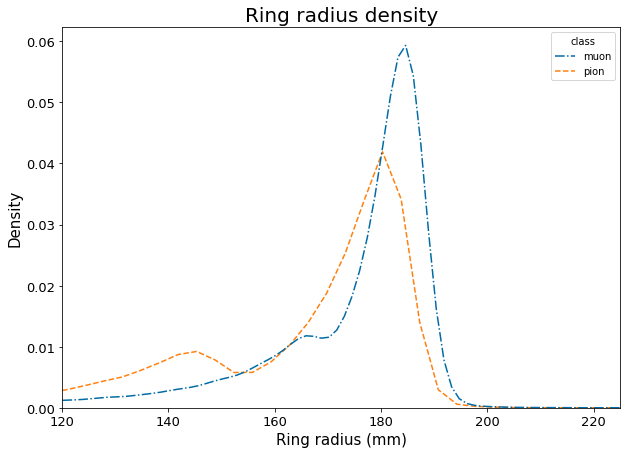

In [34]:
df=df_small_combined
plt.figure(figsize=(10, 7))
g = sns.kdeplot(
    x=df.query("ring_radius < 999999.000")["ring_radius"],
    hue=df.query("ring_radius < 999999.000")["class"],
    common_norm=False,
)

plt.title("Ring radius density", fontsize=20)
plt.xlabel("Ring radius (mm)", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(120, 225)

handles = g.legend_.legendHandles[::-1]

for line, ls, handle in zip(g.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)


plt.show()

## Distribution of ring radius for momentum bins of 1 GeV post sub-sampling

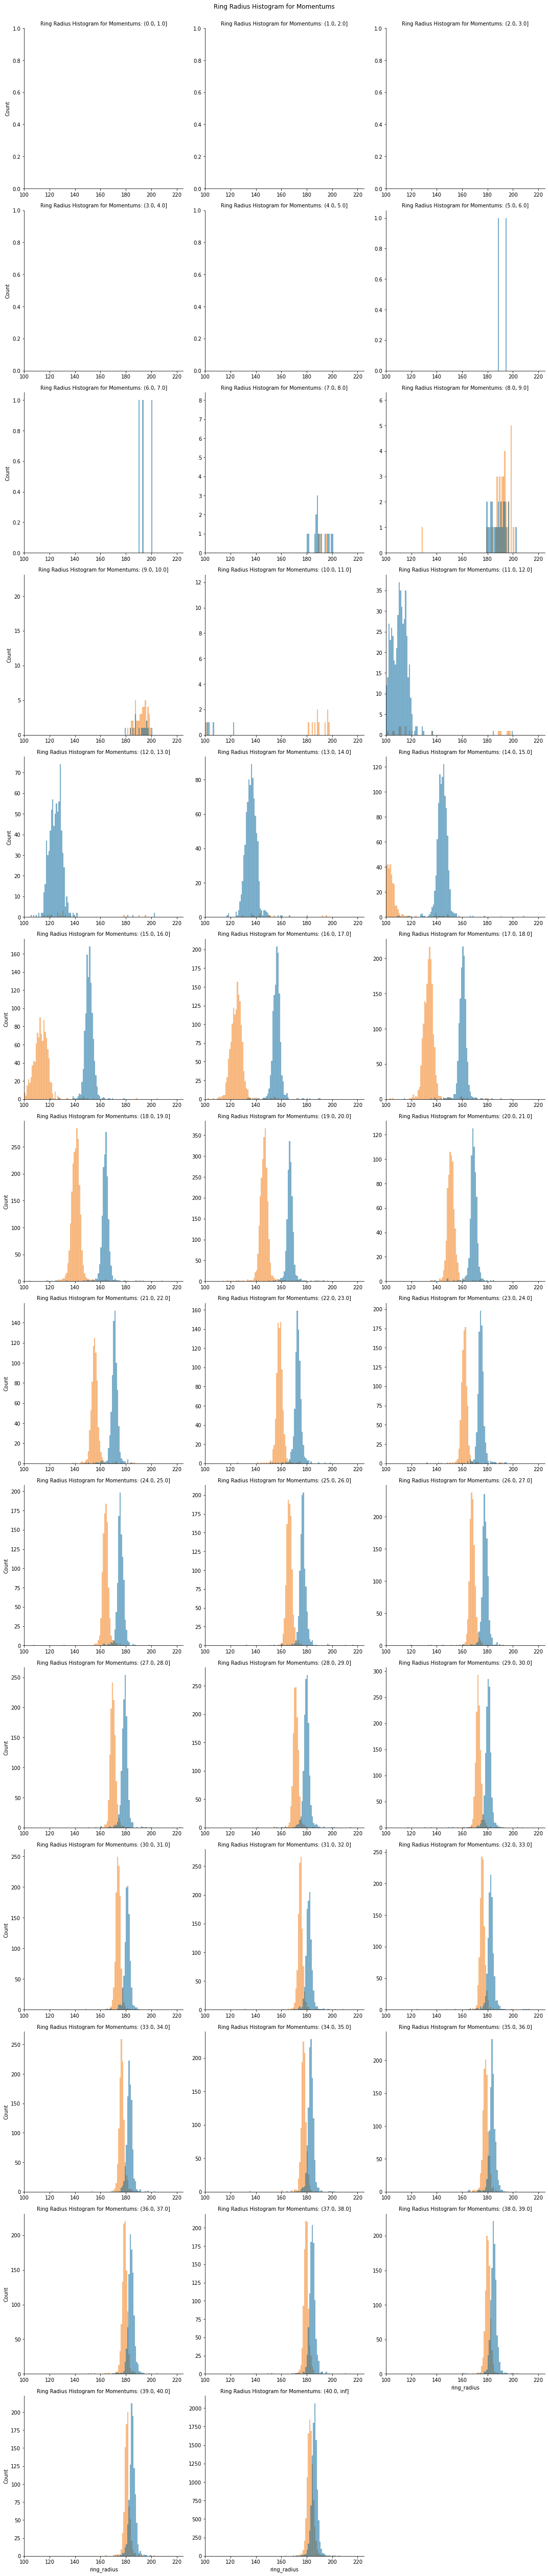

In [35]:
df=df_small_combined
g = sns.displot(
    data=df.query("ring_radius < 999999.000"),
    x="ring_radius",
    col="narrow_momentum_bin",
    hue="class",
    col_wrap=3,
    facet_kws=dict(sharey=False, sharex=False),
    binwidth=1,
    legend=False
);

for ax in g.axes:
    ax.set_xlim(100, 225)

g.set_titles("Ring Radius Histogram for Momentums: {col_name}")
g.fig.suptitle("Ring Radius Histogram for Momentums", y=1)
g.tight_layout()

plt.show()

<!-- ## Location of Ring Centres for Each Particle -->

## Ring centre locations for each particle post sub-sampling

- Some patterns observed in locations of ring centres, but based on discussion w/ Bob this is biased.

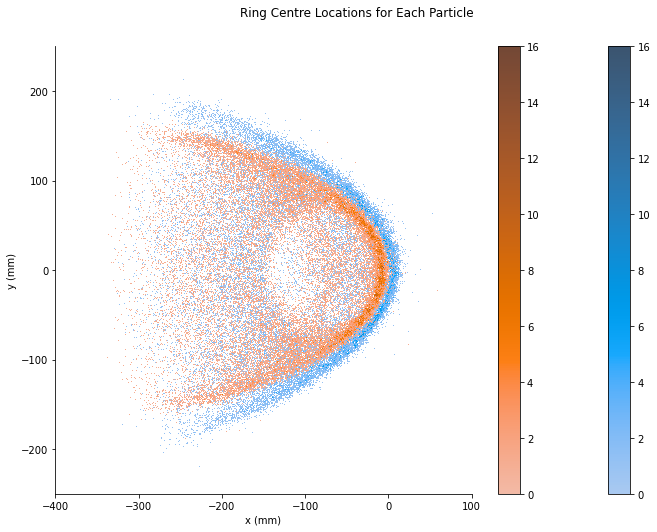

In [44]:
df=df_small_combined

g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_x"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_y"],
    #col=df.query("ring_centre_pos_y < 500000.000")["class"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    legend=False,
    cbar=True, 
    binwidth=(1, 1)
    #col_wrap=1
);

g.fig.set_figheight(7)
g.fig.set_figwidth(10)
g.set_axis_labels("x (mm)", "y (mm)")
g.set_titles("Ring Centres for Label: {col_name}")
g.tight_layout()
g.set(xlim=(-400, 100))
g.set(ylim=(-250, 250))
g.fig.suptitle("Ring Centre Locations for Each Particle", y=1.05)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


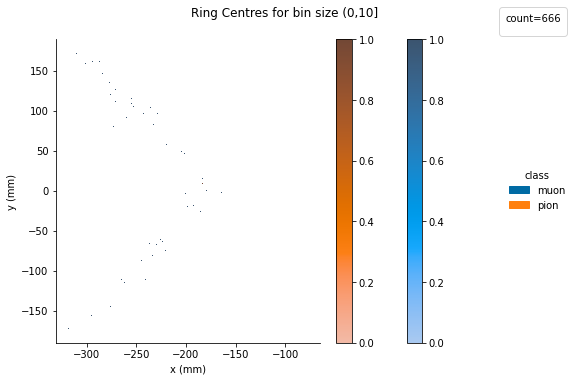

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


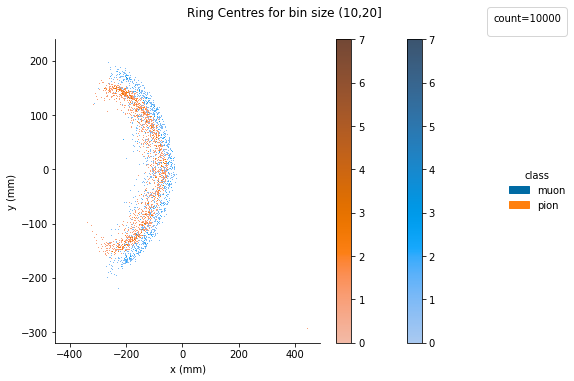

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


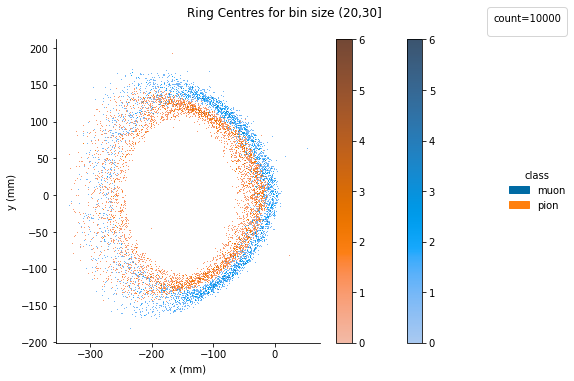

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


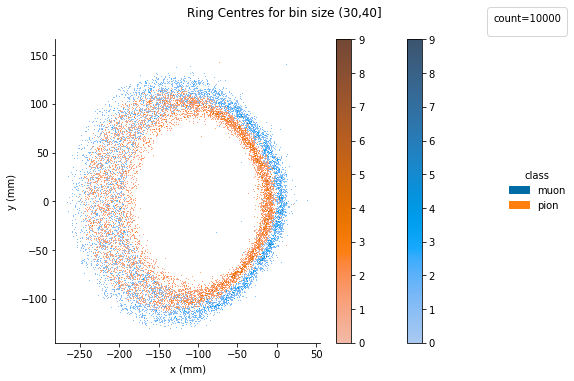

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


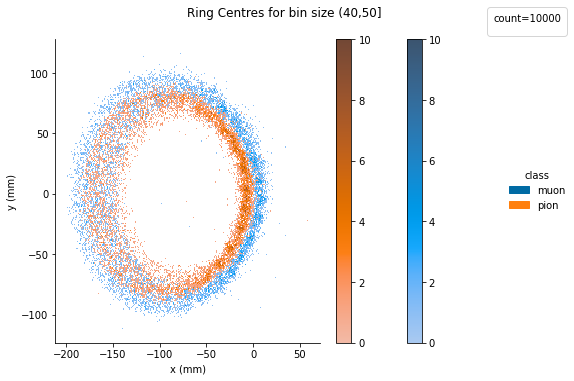

In [37]:
for key, value in df_small.items():
    g = sns.displot(
        x=value.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_x"],
        y=value.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_y"],
        #col=df.query("ring_centre_pos_y < 500000.000")["class"],
        hue=value.query("ring_centre_pos_y < 500000.000")["class"],
        legend=True,
        cbar=True, 
        binwidth=(1, 1)
        #col_wrap=1, 
    );

    g.fig.set_figheight(5)
    g.fig.set_figwidth(8)
    g.set_axis_labels("x (mm)", "y (mm)")
    #g.set_titles("Ring Centres for {col_name}" + f" for bin size {key}")
    g.tight_layout()
    g.fig.suptitle(f"Ring Centres for bin size {key}", y=1.05)
    g.fig.legend(title=f"count={value.label.value_counts()[0]}", 
                fontsize=15)
    plt.show()

## Track momentum vs. Ring radius

- We can see separation in the plot from about 10GeV to 40 GeV

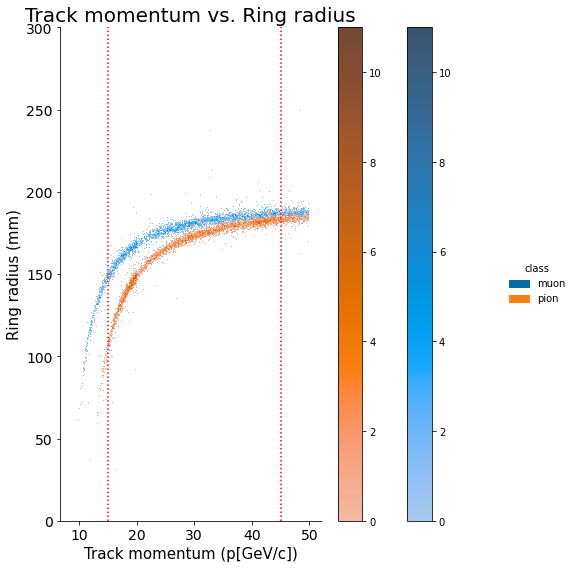

In [78]:
df=df_small_combined

g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["track_momentum"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_radius"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    cbar=True, 
    binwidth=(0.1, 0.1)
);

g.ax.set_title("Track momentum vs. Ring radius", fontsize=20)
g.set_axis_labels("Track momentum (p[GeV/c])", "Ring radius (mm)", fontsize=15)
g.set_titles("Ring Centres for Label: {col_name}")
g.ax.tick_params(axis='x', labelsize= 14)
g.ax.tick_params(axis='y', labelsize= 14)
g.ax.set_ylim([0, 300])    # some noise above 300 makes the plot ugly
g.fig.set_figheight(8)
g.fig.set_figwidth(8)
g.tight_layout()

plt.axvline(15, color="red", linestyle="dotted")
plt.axvline(45, color="red", linestyle="dotted")
#plt.plot(ptrk_mev/1000, mu_ring_rad*1000, color='r')
#plt.plot(ptrk_mev/1000, pi_ring_rad*1000, color='r')

#plt.show()

In [39]:
import sys
import numpy as np
import matplotlib.pyplot as plt

df=df_small_combined.query('ring_radius<3000')

# MeV/c^2
M_PI_MEV = 139.57
M_MU_MEV = 105.66
M_E_MEV = 0.511

# Units conversion
MEV_TO_GEV = 1e-3
M_TO_MM = 1e3

def calc_ring_radius(p,label):
    """
        Returns the expected ring radius [m]
        m : mass of the particle in MeV/c^2
        p : track momentum in MeV/c
    """
    F_M = 17.0 # Focal length [m]
    N = 1 + 62.8e-6 # Neon refractive index
    
    if label==0:
        m=M_MU_MEV
    else: 
        m=M_PI_MEV
    
    r = F_M*N*p*np.sqrt(1 - (m**2 + p**2)/(N**2*p**2))/np.sqrt(m**2 + p**2)
    return r

df['expected_radius']=df.apply(lambda x: calc_ring_radius(x.track_momentum*1000, x.label)*1000, axis=1)
df['delta_radius']=df['expected_radius'] - df['ring_radius']

/tmp/ipykernel_57582/2577862333.py:30: RuntimeWarning: invalid value encountered in sqrt
  r = F_M*N*p*np.sqrt(1 - (m**2 + p**2)/(N**2*p**2))/np.sqrt(m**2 + p**2)
/tmp/ipykernel_57582/2577862333.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expected_radius']=df.apply(lambda x: calc_ring_radius(x.track_momentum*1000, x.label)*1000, axis=1)
/tmp/ipykernel_57582/2577862333.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_radius']=df['expected_radius'] - df['ring_radius']


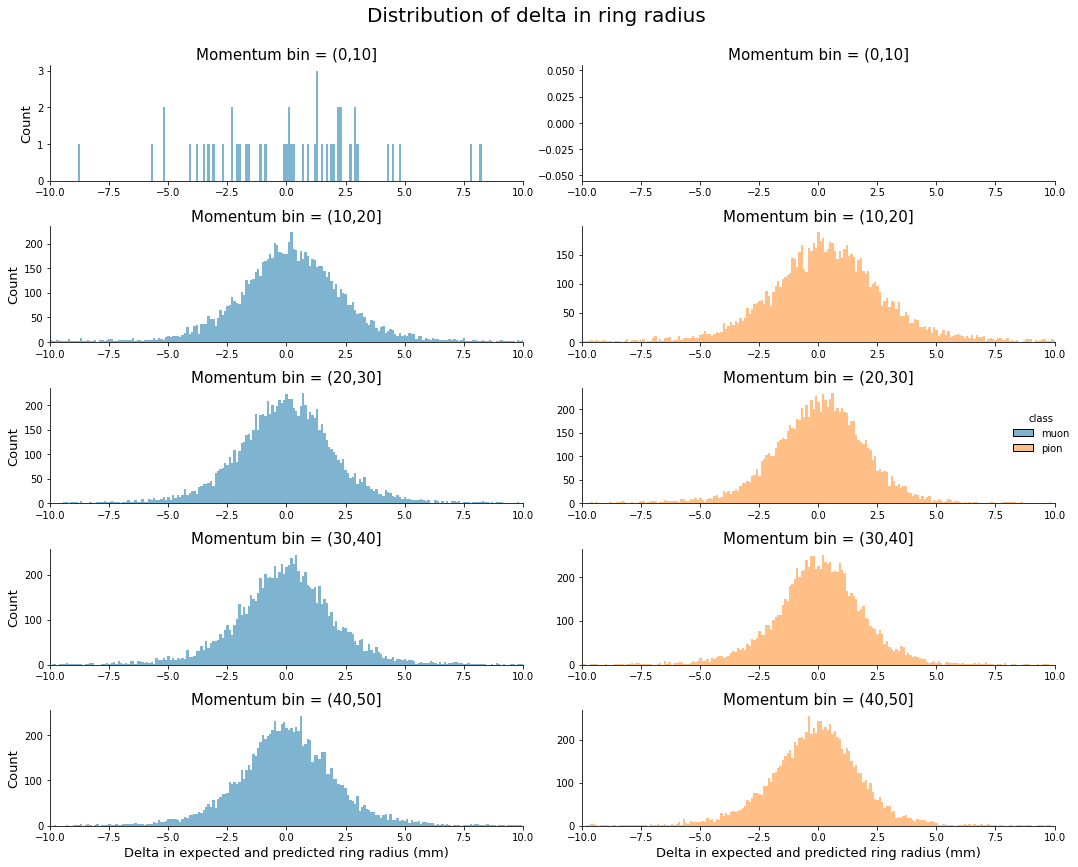

In [40]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["delta_radius"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    col=df.query("ring_centre_pos_y < 500000.000")["class"],
    row=df.query("ring_centre_pos_y < 500000.000")["wide_momentum_bin"],
    #hist_kws=dict(edgecolor="black", linewidth=2),
    #cbar=True, 
    binwidth=(0.1),
    #col_wrap=1,
    facet_kws=dict(sharey=False, sharex=False),
    legend=True
);

g.fig.suptitle("Distribution of delta in ring radius", y=1, fontsize=20)
g.set_titles("Momentum bin = {row_name}", size=15)
g.set_xlabels("Delta in expected and predicted ring radius (mm)", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(12)
g.fig.set_figwidth(15)
g.set(xlim=(-10, 10))

#for ax in g.axes:
#    ax.set_xlim(-10, 10)

plt.tight_layout()
plt.show()

# Plots: Distribution of deltas for filtered hits
### Delta=0.3

In [54]:
df_clean=balanced_df_combined

df_delta=delta(dset_unbalanced, 
              df_clean, 
              )

g = sns.displot(
    data=df_delta,
    x="mean_delta",
    col="class",
    hue="class",
    binwidth=0.025,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

NameError: name 'dset_unbalanced' is not defined

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

## Note - some events have no hits

<div class="alert alert-info" style="color:black">
Confirmed w/ TRIUMF that sometimes there may be no hits for an event.
</div>

In [ ]:
df.query("total_hits < 0")

In [ ]:
f["HitMapping"][162477]

In [ ]:
f["HitMapping"][162478]

In [ ]:
f["HitMapping"][180079]

In [ ]:
f["HitMapping"][180080]

In [ ]:
# remove the last row of the df due to problems discussed prior
hits_df = df.iloc[:-1, :]

# only plot positive number of hits for problems discussed prior
hits_df = hits_df.query("total_hits > 0")

## Histograms of Total # of Hits by Particle

- Axis cut off at 200 here, there are some events with more hits but very few.

In [ ]:
hits_df=df_small_combined
g = sns.displot(
    data=hits_df,
    x="total_hits",
    col="class",
    hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Total number of hits histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Total hits per event", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
g.fig.legend(title=f"count={df_small_combined.label.value_counts()[0]}", 
                fontsize=15)

for ax in g.axes:
    ax.set_xlim(0, 200)
    
plt.tight_layout()
plt.show()

In [ ]:
muon_df=pd.DataFrame(ç)

g = sns.displot(
    data=muon_df,
    x=0,
    #col="class",
    #hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Total number of hits histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Total hits per event", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
g.fig.legend(title=f"count={df_small_combined.label.value_counts()[0]}", 
                fontsize=15)

for ax in g.axes:
    ax.set_xlim(0, 200)
    
plt.tight_layout()
plt.show()

## Distribution of hit time deltas 

## Boxplots of Total # of Hits by Particle

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=hits_df, x="total_hits", y="class")
plt.title("Distribution of total hits per particle", fontsize=20)
plt.xlabel("Total hits per event", fontsize=15);
plt.ylabel("Class", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Distribution of hit time deltas (hit - chod) for 25 events for each particle

- Red line is zero
- Muons look OK, pion and positron to discuss...

In [ ]:
samples = get_class_samples(hits_df, n=10, seed=42)

for i in samples.index:
    plt.figure(figsize=(10, 5))
    hit_info = get_hit_info_df(f, samples, i)

    label = hit_info["class"].unique()[0]
    momentum = samples.loc[i]['track_momentum']
    total_hits = samples.loc[i]['total_hits']
    title = f"Event {i}: {label} \n Momentum: {momentum:2f} \n Total hits: {total_hits}"

    if label == "muon":
        color = "#1170aa"
    elif label == "pion":
        color = "#fc7d0b"
    elif label == "positron":
        color = "#a3acb9"

    sns.histplot(hit_info["chod_delta"], color=color, binwidth=1)
    plt.title(title)
    plt.xlabel("Time delta")
    plt.axvline(0, color="red", linewidth=3, linestyle="dashed")
    plt.show()

## Ring plots

In [ ]:
#verifying that the mapping is working
df1 = pd.read_hdf("/fast_scratch_1/capstone_2022/datasetC_combined.h5")
df2 = events_to_pandas(f)
(df1.reset_index()['track_momentum'] == df2.iloc[df1.original_index, :].reset_index()['track_momentum']).value_counts()

In [ ]:
# this is an example pandas df that is used for plotting
hit_data = get_hit_data(f, event=1)
hit_data_df = hit_data_to_pandas(hit_data)
hit_data_df["x_realigned"] = hit_data_df.apply(
    lambda a: realign_x_hits(a.x, a.mirror), axis=1
)
hit_data_df["y_realigned"] = hit_data_df.apply(
    lambda a: realign_y_hits(a.y, a.mirror), axis=1
)

hit_data_df

In [ ]:
np.random.seed(111)

# plot 10 examples
n = 10
# samples = np.random.randint(0, len(f["Events"]), size=n)

df = pd.read_hdf("/fast_scratch_1/capstone_2022/datasetC_combined.h5")
df["class"] = df["label"].apply(get_string_label)
samples = get_class_samples(df, n, 111)

cols = 3
rows = (n*2) // cols
rows += (n*2) % cols

fig, ax = plt.subplots(rows, cols, figsize=(cols * 6, 6 * rows))
ax=ax.flatten()

for i, event in enumerate(samples.index):
    plot_event(f, mapper, event, ax[i]);

plt.tight_layout()
plt.show()